# 🤝 Customer Service Discord Bot with Agentic RAG Powered by a local model deployment, using 🐫 CAMEL, Firecrawl & Qdrant

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
  Join our Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/camel-ai/camel">Github</a> </i> ⭐
</div>


## Installation and Setup
First, install the CAMEL package with all its dependencies

In [ ]:
!pip install "camel-ai[all]==0.2.15a0"
!pip install starlette
!pip install nest_asyncio

Next, prepare the knowledge base with Firecrawl. Firecrawl is a versatile web scraping and crawling tool designed to extract data efficiently from websites, which has been integrated with CAMEL. For more information, you can check out our Firecrawl cookbook: https://colab.research.google.com/drive/1lOmM3VmgR1hLwDKdeLGFve_75RFW0R9I?usp=sharing#scrollTo=1Nj0Oqnoy6oJ

Let's set up your Firecrawl! You may skip this part if you already have your knowledge file.

In order to run everything locally, we can use self-hosted firecrawl.

For more details, please check out firecrawl documentation: https://docs.firecrawl.dev/contributing/guide

In [5]:
from getpass import getpass

firecrawl_api_url = getpass('Enter your API url: ')

Enter your API url: ··········


## Local setup


Please **make a copy** of this notebook (important), or run this notebook locally.

If you choose to make a copy of this notebook and stay in Google colab, connect the copied notebook to your local runtime by follow the following steps:

1. Install notebook locally by running the following command in your terminal:
```bash
  pip install notebook
```
```bash
  jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' \
                 --port=8888 \
                 --no-browser
```
You will see something like this in your terminal:
```bash
  To access the server, open this file in a browser:
        <some_path>
    Or copy and paste one of these URLs:
        <url1>
        <url2>
```
2. Copy any of the url, and click on 'connect to a local runtime' button in Google Colab, and paste the copied url into Backend Url.
3. Click on 'connect'

## Basic Agent and local model Setup

1. Download Ollama for a local model at: https://ollama.com/download
2. After setting up Ollama, pull the Llama3 model by typing the following command into the terminal:
  ```bash
  ollama pull qwq

3. cd into a desired directory
```bash
  cd <target_drectory_path>

4. Create a `ModelFile` similar the one below in your project directory. (Optional)
```bash
  FROM qwq

  # Set parameters
  PARAMETER temperature 0.8
  PARAMETER stop Result

  # Sets a custom system message to specify the behavior of the chat assistant
  # Leaving it blank for now.

  SYSTEM """ """
```

5. Create a script to get the base model (llama3) and create a custom model using the `ModelFile` above. Save this as a .sh file: (Optional)
```bash
  #!/bin/zsh

  # variables
  model_name="qwq"
  custom_model_name="camel-qwq"

  #get the base model
  ollama pull $model_name

  #create the model file
  ollama create $custom_model_name -f ./ModelFile
```



Now you have the local model deployed!

In [37]:
from camel.models import ModelFactory
from camel.types import ModelPlatformType

ollama_model = ModelFactory.create(
    model_platform=ModelPlatformType.OLLAMA,
    model_type="qwq",
    url="http://localhost:11434/v1", #optional
    model_config_dict={"temperature": 0.4},
)


In [56]:
from camel.agents import ChatAgent

chat_agent = ChatAgent(
    system_message="You're a helpful assistant",
    message_window_size=10,
    model=ollama_model,
    token_limit=8192, #change base on your input size
)

## Knowledge Crawling and Storage

Use Firecrawl to crawl a website and store the content in a markdown file:

In [23]:
import os
from camel.loaders import Firecrawl
from camel.messages import BaseMessage

os.makedirs('local_data', exist_ok=True)

firecrawl = Firecrawl(api_url=firecrawl_api_url, api_key="_")

crawl_response = firecrawl.crawl(
    url="https://docs.camel-ai.org/"
)

with open('local_data/camel.md', 'w') as file:
     file.write(crawl_response["data"][0]["markdown"])

Insert the external knowledge to Agent

In [57]:
with open('local_data/camel.md', 'r') as file:
  knowledge = file.read()

knowledge_message = BaseMessage.make_user_message(
    role_name="User", content=f"Based on the following knowledge: {knowledge}"
)
chat_agent.update_memory(knowledge_message, "user")

## Basic Chatbot Setup

In [58]:
print("Start chatting! Type 'exit' to end the conversation.")
while True:
    user_input = input("User: ")

    if user_input.lower() == "exit":
        print("Ending conversation.")
        break

    assistant_response = chat_agent.step(user_input)
    print(f"Assistant: {assistant_response.msgs[0].content}")

Start chatting! Type 'exit' to end the conversation.
User: what is camel?
2024-12-27 14:42:04,297 - httpx - INFO - HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-27 14:42:04,300 - camel.agents.chat_agent - INFO - Model qwq, index 0, processed these messages: [{'role': 'system', 'content': "You're a helpful assistant"}, {'role': 'user', 'content': 'Based on the following knowledge: [Skip to main content](#main-content)\n\nBack to top Ctrl+K\n\n [![](https://raw.githubusercontent.com/camel-ai/camel/master/misc/logo_light.png) ![](https://raw.githubusercontent.com/camel-ai/camel/master/misc/logo_light.png)\\\n\\\nCAMEL 0.2.14](#)\n\nSearch Ctrl+K\n\n*   [.rst](_sources/index.rst "Download source file")\n    \n*   .pdf\n\nWelcome to CAMEL’s documentation!\n=================================\n\nContents\n--------\n\nWelcome to CAMEL’s documentation![#](#welcome-to-camel-s-documentation "Link to this heading")\n\n=======================================

## Basic Discord Bot Integration

To build a discord bot, a discord bot token is necessary.

If you don't have a bot token, you can obtain one by following these steps:
1. Go to the Discord Developer Portal:https://discord.com/developers/applications
2. Log in with your Discord account, or create an account if you don't have one
3. Click on 'New Application' to create a new bot.
4. Give your application a name and click 'Create'.
5. Navigate to the 'Bot' tab on the left sidebar and click 'Add Bot'.
6. Once the bot is created, you will find a 'Token' section. Click 'Reset Token' to generate a new token.
7. Copy the generated token securely.

To invite the bot:
1. Navigate to the 'OAuth2' tab, then to 'URL Generator'.
2. Under 'Scopes', select 'bot'.
3. Under 'Bot Permissions', select the permissions your bot will need (e.g., 'Send Messages', 'Read Messages' for our bot use)
4. Copy the generated URL and paste it into your browser to invite the bot to your server.

To grant the bot permissions:
1. Navigate to the 'Bot' tab
2. Under 'Privileged Gateway Intents', check 'Server Members Intent' and 'Message Content Intent'.

For more details, you can also check the official Discord bot documentation: https://discord.com/developers/docs/intro


In [ ]:
import os
from getpass import getpass

discord_bot_token = getpass('Enter your Discord bot token: ')
os.environ["DISCORD_BOT_TOKEN"] = discord_bot_token

Enter your Discord bot token: ··········


This code cell sets up a simple Discord bot using the DiscordApp class from the camel.bots library. The bot listens for messages in any channel it has access to and provides a response based on the input message.

In [ ]:
from camel.bots import DiscordApp
import nest_asyncio
import discord

nest_asyncio.apply()
discord_bot = DiscordApp(token=discord_bot_token)

@discord_bot.client.event
async def on_message(message: discord.Message):
    if message.author == discord_bot.client.user:
        return

    if message.type != discord.MessageType.default:
        return

    if message.author.bot:
        return
    user_input = message.content
    chat_agent.reset()
    chat_agent.update_memory(knowledge_message, "user")
    assistant_response = chat_agent.step(user_input)

    response_content = assistant_response.msgs[0].content

    if len(response_content) > 2000: # discord message length limit
        for chunk in [response_content[i:i+2000] for i in range(0, len(response_content), 2000)]:
            await message.channel.send(chunk)
    else:
        await message.channel.send(response_content)

discord_bot.run()

2024-12-05 18:11:30 INFO     discord.client logging in using static token
INFO:discord.client:logging in using static token
2024-12-05 18:11:31 INFO     discord.gateway Shard ID None has connected to Gateway (Session ID: 18b507aabdd91f2cdcbf70d7f010191d).
INFO:discord.gateway:Shard ID None has connected to Gateway (Session ID: 18b507aabdd91f2cdcbf70d7f010191d).


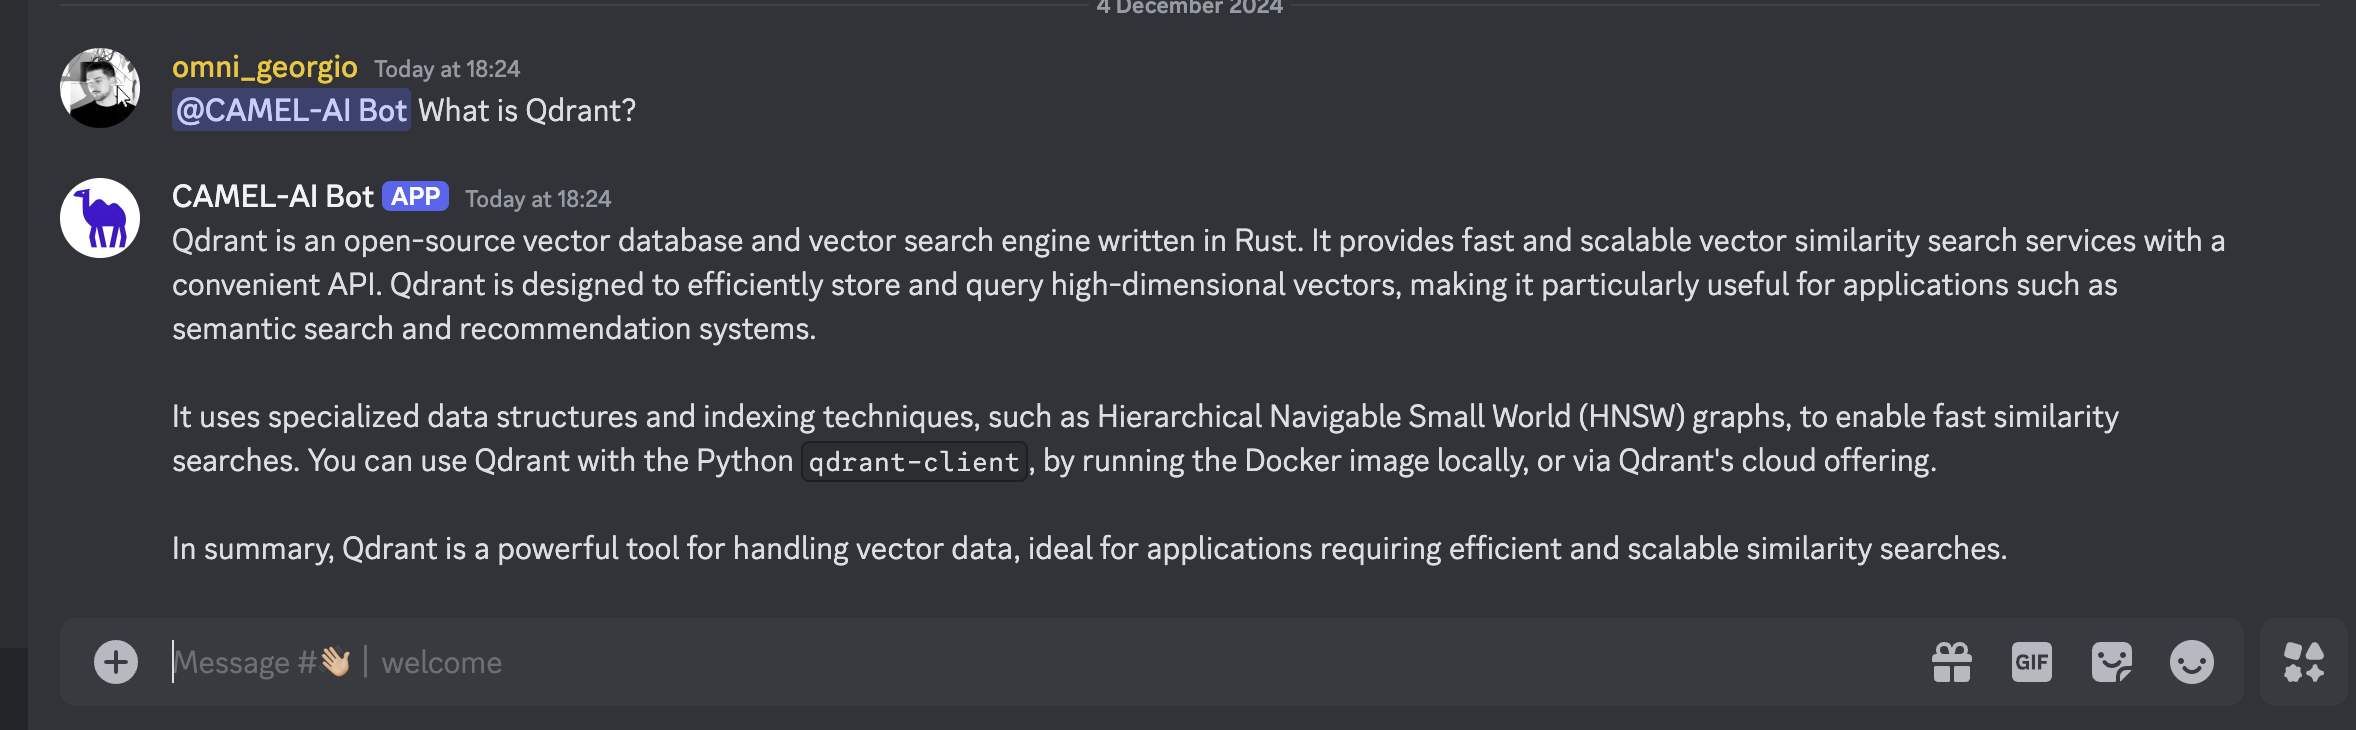

## Integrating Qdrant for Large Files to build a more powerful Discord bot

Qdrant is a vector similarity search engine and vector database. It is designed to perform fast and efficient similarity searches on large datasets of vectors. This enables the chatbot to access and utilize external information to provide more comprehensive and accurate responses. By storing knowledge as vectors, Qdrant enables efficient semantic search, allowing the chatbot to find relevant information based on the meaning of the user's query.

Set up an embedding model and retriever for Qdrant: You can use Tesla T4 Google Colab instance for running open-source embedding models with RAG functionality for bots, feel free switch to other embedding models supported by CAMEL.

Set up an embedding model and retriever for Qdrant:

In [ ]:
from camel.embeddings import SentenceTransformerEncoder # CAMEL also support other embedding

sentence_encoder = SentenceTransformerEncoder(model_name='intfloat/e5-large-v2')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-12-05 18:12:54.845321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 18:12:54.864069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 18:12:54.869936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 18:12:54.884872: I tensorflow/core/platform/cpu_feature_guard.cc:21

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Set up the AutoRetriever for automatically retrieving relevant information from a storage system.

In [ ]:
from camel.retrievers import AutoRetriever
from camel.types import StorageType

assistant_sys_msg = """You are a helpful assistant to answer question,
         I will give you the Original Query and Retrieved Context,
        answer the Original Query based on the Retrieved Context,
        if you can't answer the question just say I don't know.
        Just give the answer to me directly, no more other words needed.
        """
auto_retriever = AutoRetriever(
              vector_storage_local_path="local_data2/",
              storage_type=StorageType.QDRANT,
              embedding_model=sentence_encoder
            )
chat_agent_with_rag = ChatAgent(system_message=assistant_sys_msg, model=ollama_model)

Use Auto RAG to retrieve first and then answer the user's query using CAMEL `ChatAgent` based on the retrieved info:

In [ ]:
from camel.bots import DiscordApp
import nest_asyncio
import discord

nest_asyncio.apply()
discord_q_bot = DiscordApp(token=discord_bot_token)

@discord_q_bot.client.event # triggers when a message is sent in the channel
async def on_message(message: discord.Message):
    if message.author == discord_q_bot.client.user:
        return

    if message.type != discord.MessageType.default:
        return

    if message.author.bot:
        return
    user_input = message.content

    query_and_retrieved_info = auto_retriever.run_vector_retriever(
        query=user_input,
        contents=[
            "local_data/qdrant_overview.md",
        ],
        top_k=3,
        return_detailed_info=False,
        similarity_threshold=0.5
    )

    user_msg = str(query_and_retrieved_info)
    assistant_response = qdrant_agent.step(user_msg)
    response_content = assistant_response.msgs[0].content

    if len(response_content) > 2000: # discord message length limit
        for chunk in [response_content[i:i+2000] for i in range(0, len(response_content), 2000)]:
            await message.channel.send(chunk)
    else:
        await message.channel.send(response_content)

discord_q_bot.run()

2024-12-05 18:13:16 INFO     discord.client logging in using static token
2024-12-05 18:13:16 INFO     discord.client logging in using static token
INFO:discord.client:logging in using static token
2024-12-05 18:13:17 INFO     discord.gateway Shard ID None has connected to Gateway (Session ID: 05c4332a395af2dfb6c69abf8779a92a).
2024-12-05 18:13:17 INFO     discord.gateway Shard ID None has connected to Gateway (Session ID: 05c4332a395af2dfb6c69abf8779a92a).
INFO:discord.gateway:Shard ID None has connected to Gateway (Session ID: 05c4332a395af2dfb6c69abf8779a92a).


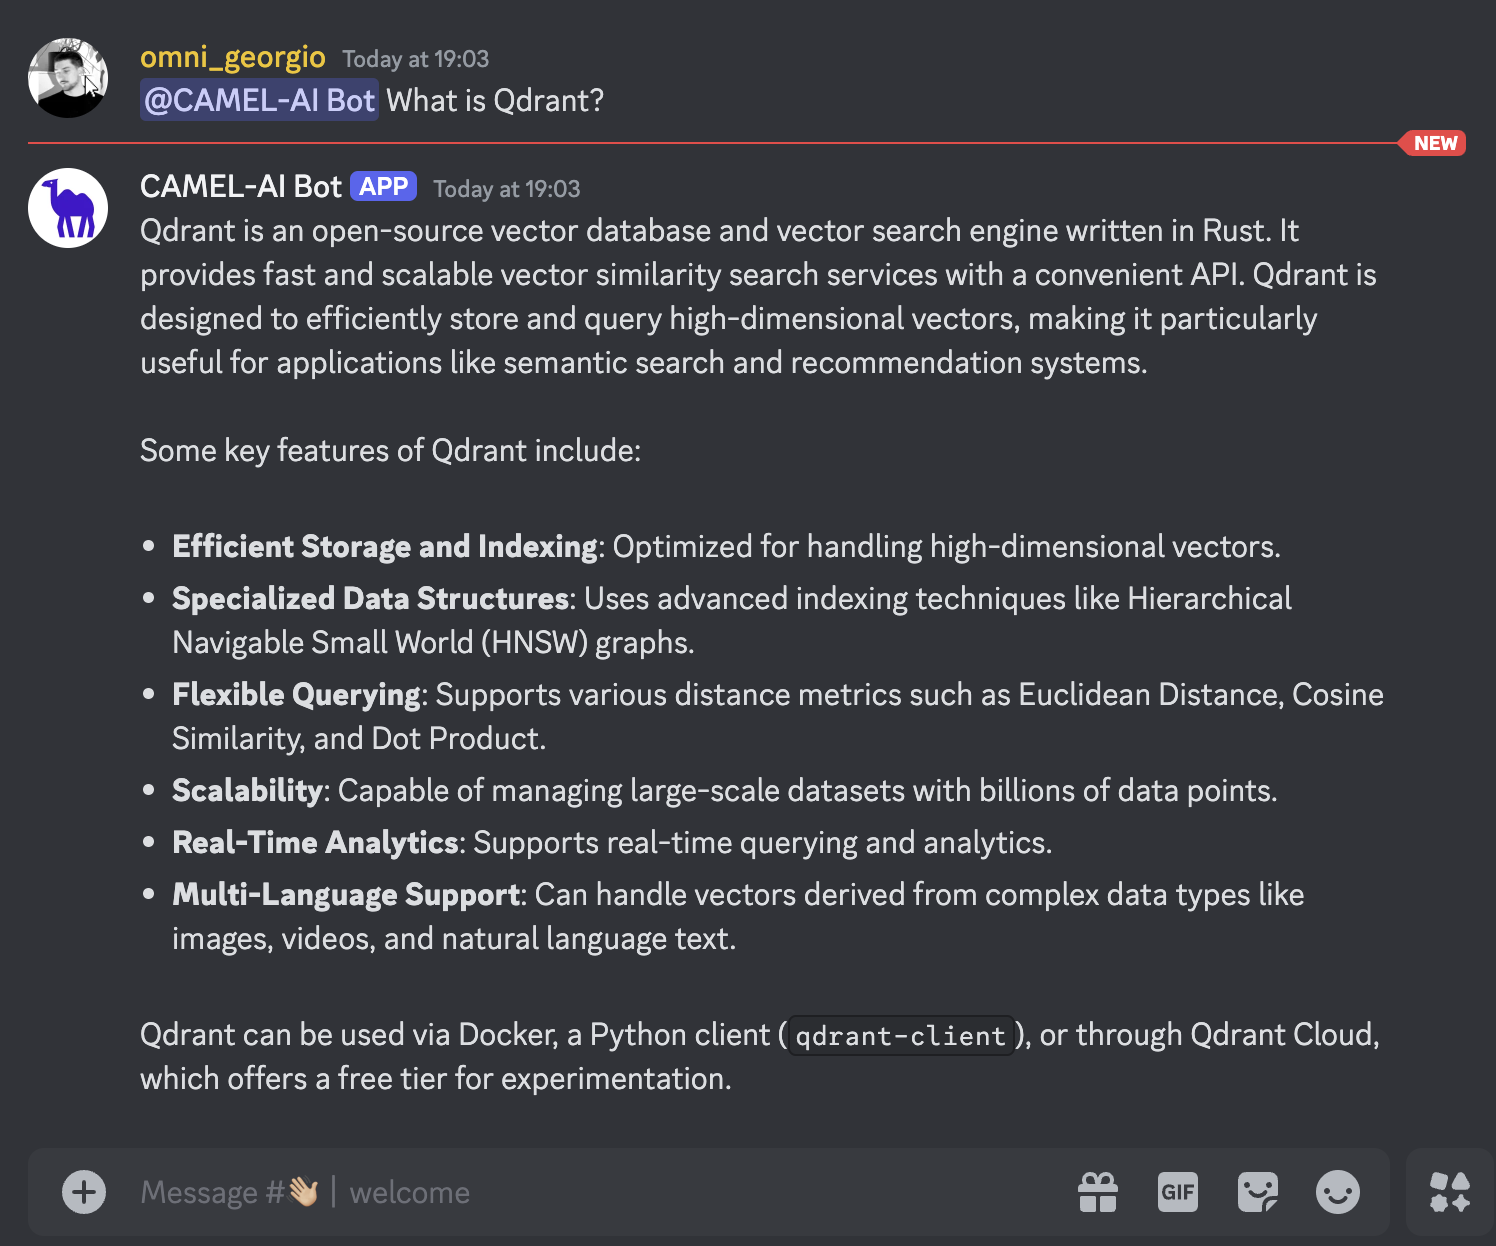

That's everything: Got questions about 🐫 CAMEL-AI? Join us on [Discord](https://discord.camel-ai.org)! Whether you want to share feedback, explore the latest in multi-agent systems, get support, or connect with others on exciting projects, we’d love to have you in the community! 🤝

Check out some of our other work:
1. 🐫 Creating Your First CAMEL Agent [free Colab](https://docs.camel-ai.org/cookbooks/create_your_first_agent.html)
2.  Graph RAG Cookbook [free Colab](https://colab.research.google.com/drive/1uZKQSuu0qW6ukkuSv9TukLB9bVaS1H0U?usp=sharing)
3. 🧑‍⚖️ Create A Hackathon Judge Committee with Workforce [free Colab](https://colab.research.google.com/drive/18ajYUMfwDx3WyrjHow3EvUMpKQDcrLtr?usp=sharing)
4. 🔥 3 ways to ingest data from websites with Firecrawl & CAMEL [free Colab](https://colab.research.google.com/drive/1lOmM3VmgR1hLwDKdeLGFve_75RFW0R9I?usp=sharing)
5. 🦥 Agentic SFT Data Generation with CAMEL and Mistral Models, Fine-Tuned with Unsloth [free Colab](https://colab.research.google.com/drive/1lYgArBw7ARVPSpdwgKLYnp_NEXiNDOd-?usp=sharingg)

Thanks from everyone at 🐫 CAMEL-AI


<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on <a href="https://github.com/camel-ai/camel">Github</a> </i>, join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)  ⭐
</div>
